<a href="https://colab.research.google.com/github/aladelca/MAIA_aprendizaje_refuerzo_profundo/blob/master/LunarLander_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LunarLander con DQN (Stable-Baselines3)

Este notebook entrena y evalúa un agente DQN de Stable-Baselines3 para el ambiente discreto `LunarLander-v3` de Gymnasium.

- Método: DQN de SB3 con red MLP, experiencia repetida, target updates y exploración epsilon.
- Ambiente: `LunarLander-v3` (acciones: 0=No-op, 1=Motor Izq., 2=Motor Principal, 3=Motor Der.).
- Objetivo: Aterrizar en la zona plana entre banderas (centro), robusto a variaciones del terreno.
- Hardware: CPU.
- Evita logs con `verbose = False`

Incluye entrenamiento con `EvalCallback` y checkpoints, evaluación con y sin vientos, para mayor robustez, y gráficos de aprendizaje y grabación de video.

## Instalación e importación de dependencias

In [1]:
# Instalación de dependencias
# swig debe instalarse antes que box2d
%pip install -q swig
%pip install -q gymnasium[box2d] # instalar en una nueva línea para evitar errores en colab
%pip install -q stable-baselines3 matplotlib imageio imageio-ffmpeg
#%pip install -q tensorboard tqdm

from IPython.display import clear_output
clear_output()
print("Librerías instaladas correctamente.")

Librerías instaladas correctamente.


In [2]:
import sys, platform
import imageio
import gymnasium as gym
import numpy as np
import random
import os
import matplotlib.pyplot as plt
#from tqdm.auto import trange, tqdm
from IPython.display import Video, display

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import ts2xy, load_results, plot_results

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

clear_output()
print('Usando Stable-Baselines3 DQN')

Usando Stable-Baselines3 DQN


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Definición del ambiente

In [3]:
# Definir el ambiente
def make_env(seed: int = SEED, render_mode=None, enable_wind: bool = False, **kwargs):
    env = gym.make('LunarLander-v3', render_mode=render_mode, enable_wind=enable_wind, **kwargs)
    env = Monitor(env) # para registrar las recompensas
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

# Verificar espacios
_env = make_env()
clear_output()
print('Espacio de estados:', _env.observation_space.shape[0], ', Espacio de acciones:', _env.action_space.n)
_env.close()

Espacio de estados: 8 , Espacio de acciones: 4


In [4]:
# Hiperparámetros
TIMESTEPS = 300_000  # Ajustado según el tiempo disponible
POLICY_KWARGS = dict(net_arch=[256, 256])
LEARNING_RATE = 1e-3
GAMMA = 0.99
BUFFER_SIZE = 100_000
LEARNING_STARTS = 5_000
TRAIN_FREQ = 4
TARGET_UPDATE_INTERVAL = 1_000
TAU = 1.0
EXPLORATION_FRACTION = 0.35 # 0.5
EXPLORATION_FINAL_EPS = 0.05
BATCH_SIZE = 64

In [5]:
# Utilidades SB3: callbacks de evaluación y checkpoints

log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)
eval_env = make_env(seed=SEED + 100, enable_wind=False)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=os.path.join(log_dir, 'best_model'),
    log_path=log_dir,
    eval_freq=10_000,
    deterministic=True,
    render=False,
    n_eval_episodes=10,
)

checkpoint_callback = CheckpointCallback(
    save_freq=50_000,
    save_path=os.path.join(log_dir, 'checkpoints'),
    name_prefix='dqn_lunar',
    save_replay_buffer=True,
    save_vecnormalize=False,
)

## Definición del agente y entrenamiento

In [6]:
# Construir y entrenar el modelo DQN de SB3
train_env = make_env(seed=SEED, enable_wind=False)
train_env = DummyVecEnv([lambda: Monitor(train_env, log_dir)])

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    learning_starts=LEARNING_STARTS,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    train_freq=TRAIN_FREQ,
    target_update_interval=TARGET_UPDATE_INTERVAL,
    tau=TAU,
    exploration_fraction=EXPLORATION_FRACTION,
    exploration_final_eps=EXPLORATION_FINAL_EPS,
    policy_kwargs=POLICY_KWARGS,
    tensorboard_log=log_dir,
    verbose=0,
    seed=SEED,
)

# Entrenar con callbacks
model.learn(total_timesteps=TIMESTEPS, callback=[eval_callback, checkpoint_callback], progress_bar=True)

# Guardar el modelo final
os.makedirs('models', exist_ok=True)
model_path = 'models/dqn_lunarlander_sb3'
model.save(model_path)
print('Modelo guardado en', model_path)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=10000, episode_reward=-140.90 +/- 24.04

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=-155.87 +/- 28.33

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-123.32 +/- 25.42

Episode length: 917.60 +/- 247.20

New best mean reward!

Eval num_timesteps=40000, episode_reward=-182.95 +/- 33.41

Episode length: 372.50 +/- 217.08

Eval num_timesteps=50000, episode_reward=-172.59 +/- 39.00

Episode length: 334.30 +/- 107.28

Eval num_timesteps=60000, episode_reward=-166.61 +/- 40.09

Episode length: 410.20 +/- 89.46

Eval num_timesteps=70000, episode_reward=-160.66 +/- 25.39

Episode length: 512.60 +/- 48.26

Eval num_timesteps=80000, episode_reward=11.21 +/- 11.97

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=90000, episode_reward=-16.15 +/- 15.44

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=10.74 +/- 20.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=110000, episode_reward=-14.25 +/- 16.81

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=16.57 +/- 25.14

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=130000, episode_reward=32.83 +/- 24.84

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=140000, episode_reward=23.72 +/- 23.41

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-146.69 +/- 47.13

Episode length: 482.50 +/- 258.81

Eval num_timesteps=160000, episode_reward=-7.95 +/- 14.17

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=170000, episode_reward=-7.98 +/- 14.30

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=180000, episode_reward=133.81 +/- 84.80

Episode length: 833.00 +/- 259.16

New best mean reward!

Eval num_timesteps=190000, episode_reward=-161.92 +/- 72.05

Episode length: 882.90 +/- 147.95

Eval num_timesteps=200000, episode_reward=112.39 +/- 52.75

Episode length: 834.80 +/- 259.60

Eval num_timesteps=210000, episode_reward=203.60 +/- 73.18

Episode length: 535.50 +/- 323.23

New best mean reward!

Eval num_timesteps=220000, episode_reward=227.79 +/- 83.72

Episode length: 376.70 +/- 336.96

New best mean reward!

Eval num_timesteps=230000, episode_reward=146.18 +/- 39.28

Episode length: 942.90 +/- 171.30

Eval num_timesteps=240000, episode_reward=190.10 +/- 107.92

Episode length: 360.90 +/- 237.12

Eval num_timesteps=250000, episode_reward=224.62 +/- 46.57

Episode length: 702.70 +/- 212.89

Eval num_timesteps=260000, episode_reward=183.81 +/- 139.75

Episode length: 489.20 +/- 370.24

Eval num_timesteps=270000, episode_reward=186.52 +/- 113.30

Episode length: 346.40 +/- 330.10

Eval num_timesteps=280000, episode_reward=157.61 +/- 67.69

Episode length: 763.70 +/- 361.34

Eval num_timesteps=290000, episode_reward=225.85 +/- 105.43

Episode length: 187.00 +/- 42.99

Eval num_timesteps=300000, episode_reward=265.13 +/- 37.66

Episode length: 346.90 +/- 232.08

New best mean reward!

Modelo guardado en models/dqn_lunarlander_sb3


## Resultados del entrenamiento

In [7]:
# TensorBoard: puedes lanzar un servidor para ver curvas (en Colab se integra)
# En local: desde terminal, corre: tensorboard --logdir logs | cat

# %load_ext tensorboard
# %tensorboard --logdir logs

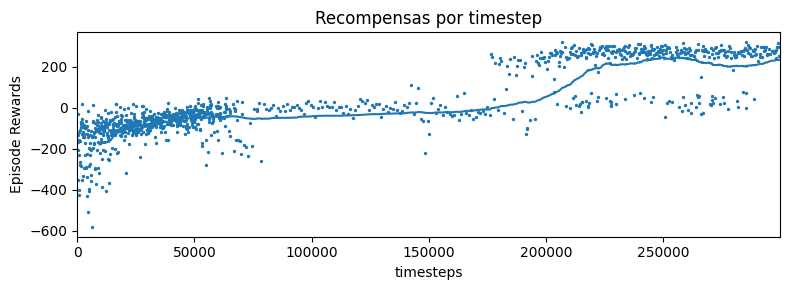

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
plot_results([log_dir], np.inf, 'timesteps', "Recompensas por timestep", figsize=(8,3))
plt.show()

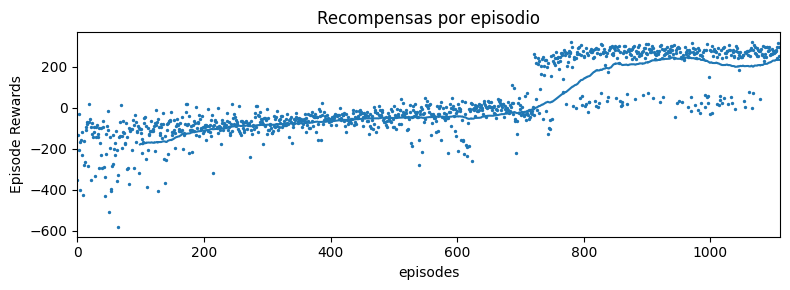

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
plot_results([log_dir], np.inf, 'episodes', "Recompensas por episodio", figsize=(8,3))
plt.show()

In [10]:
# Cargar el mejor modelo (si existe) o usar el modelo recién entrenado
best_model_dir = os.path.join(log_dir, 'best_model')
best_model_path = os.path.join(best_model_dir, 'best_model.zip')

if os.path.exists(best_model_path):
    print('Cargando mejor modelo desde', best_model_path)
    best_model = DQN.load(best_model_path)
else:
    print('No hay mejor modelo aún; se usará el modelo actual')
    best_model = model

Cargando mejor modelo desde logs/best_model/best_model.zip


In [11]:
# Grabación de video opcional (SB3)
# En Colab el video se guardará en /content.
def record_video_sb3(model: DQN, filename: str = 'videos/lunar_dqn_episode.mp4', fps: int = 30, seed: int = SEED+999):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    env = make_env(seed=seed, render_mode='rgb_array')
    frames = []
    obs, info = env.reset(seed=seed)
    for _ in range(1000):
        frame = env.render()
        frames.append(frame)
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        if terminated or truncated:
            frame = env.render()
            frames.append(frame)
            break
    env.close()
    imageio.mimwrite(filename, frames, fps=fps, quality=8)
    print('Video guardado en:', filename)

In [12]:
record_video_sb3(best_model, filename='videos/lunar_dqn_episode.mp4', fps=30)
display(Video('videos/lunar_dqn_episode.mp4', embed=True, width=500))

Video guardado en: videos/lunar_dqn_episode.mp4


## Evaluación

In [13]:
# Evaluación sin viento
eval_env_no_wind = make_env(seed=SEED + 1000, enable_wind=False)
mean_reward, std_reward = evaluate_policy(best_model, eval_env_no_wind, n_eval_episodes=100, deterministic=True)
print(f"Evaluación sin viento (100 eps): media={mean_reward:.2f} ± {std_reward:.2f}")

eval_env_no_wind.close()

Evaluación sin viento (100 eps): media=252.81 ± 40.47


In [14]:
# Evaluación con viento activado
eval_env_wind = make_env(seed=SEED + 2000, enable_wind=True, wind_power=10.0, turbulence_power=1.5)
mean_reward_wind, std_reward_wind = evaluate_policy(best_model, eval_env_wind, n_eval_episodes=100, deterministic=True)
print(f"Evaluación con viento (100 eps): media={mean_reward_wind:.2f} ± {std_reward_wind:.2f}")

eval_env_wind.close()

Evaluación con viento (100 eps): media=110.27 ± 152.06


# Referencias

- https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
- https://stable-baselines.readthedocs.io/en/master/misc/results_plotter.html#stable_baselines.results_plotter.ts2xy